In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from keras import Input
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, \
    TimeDistributed, RepeatVector, Dropout, GRU, AveragePooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, \
    precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


In [2]:
def threshold_for_max_f1(y_real, Yhat):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this func not necessarily optimized, could return to 
    doing this but not needed).
    
    Also note that we calculate f1 without using the results method
    in keras_model. This is because we need to check beforehand that
    computing f1 won't produce a NaN so we won't get an invalid value warning.
    '''
    
    #error is occuring in km.results when computing f1, because TNR, NPV are 0, implying that there
    #are no true negatives. While we added if statements to account for at least one predicted
    #negative, this does not correlate to at least one true negative. Hence, instead of using keras.results
    #we use that code by check that tn is not 0
    f1_vals = []
    for i in range(0, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

        cm = confusion_matrix(y_real, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_real, y_predict).ravel()
        
        if tn != 0:      
            TNR = (tn) / (tn + fp)
            NPV = (tn) / (tn + fn)
            f1 = 2 * (TNR * NPV) / (TNR + NPV)
        else:
            f1 = -2   
        f1_vals.append(f1)
        
    f1_vals = np.array(f1_vals)
    f1_vals = np.nan_to_num(f1_vals, nan=-1)
    return (np.argmax(f1_vals))/100

In [3]:
def plot_confusion_matrix(y_real, y_predict):
    '''
    Given y_real and y_predict, this method displays the results
    (accuracy, recall, precision, f1) followed by the plot of the confusion matrix.
    '''
    print(km.results(y_real, y_predict), '\n')
    
    classes = ['High_svi', 'Low_svi']
    cm = confusion_matrix(y_real, y_predict)
    sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [4]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [5]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [6]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [7]:
reactor_list[2]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,94.066570,22.030,0.22,2.92
2010-01-02,95.318860,21.985,0.22,3.04
2010-01-03,82.826748,21.740,0.22,3.00
2010-01-04,95.307918,21.815,0.22,2.97
2010-01-05,93.930636,21.890,0.23,2.94
...,...,...,...,...
2020-12-27,144.736842,22.540,0.23,3.41
2020-12-28,130.890052,22.535,0.24,3.10
2020-12-29,140.306122,22.660,0.25,3.15


In [8]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [9]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [11]:
join_list[1]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,88.649852,22.030,0.23,3.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,86.480363,21.985,0.18,3.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,96.370968,21.740,0.21,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,109.427609,21.815,0.21,3.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,100.929054,21.890,0.23,3.70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,159.420290,22.540,0.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,147.887324,22.535,0.26,2.91,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,152.173913,22.660,0.26,2.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)

In [13]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 54.08it/s]


In [14]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Epoch 1/3
14439/14439 [==============================] - 15s 1ms/step - loss: 0.5828 - binary_accuracy: 0.6811
Epoch 2/3
14439/14439 [==============================] - 12s 830us/step - loss: 0.4601 - binary_accuracy: 0.7294
Epoch 3/3
14439/14439 [==============================] - 12s 849us/step - loss: 0.4226 - binary_accuracy: 0.7564


In [16]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)

In [17]:
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

In [18]:
threshold

0.43

(0.8105919003115265, 0.759765625, 0.6824561403508772, 0.7190388170055453) 

Confusion matrix, without normalization
[[389 123]
 [181 912]]


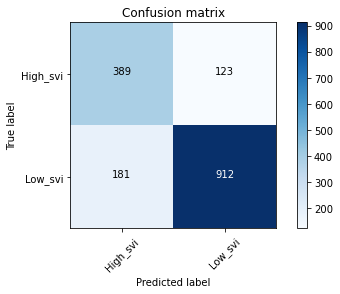

In [19]:
plot_confusion_matrix(y_real, y_predict)

In [20]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [21]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 54.27it/s]


In [22]:
auc(fpr, tpr)

0.8823889953110705

In [23]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

Text(0.5, 1.0, 'ROC curve')

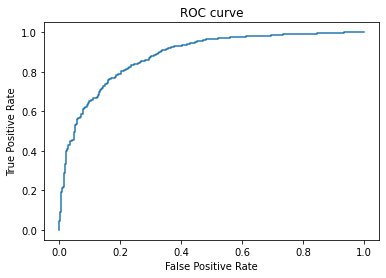

In [24]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [34]:
model_names = {1: 'Simple LSTM',
               2: 'Stacked LSTM',
               3: 'Bidirectional LSTM',
               4: 'CNN',
               5: 'CNN LSTM',
               6: 'LSTM Autoencoder',
               7: 'Deep CNN',
               8: 'GRU',
               9: 'GRU CNN'}

def plot_graphs_metrics(model, results_list, steps_in, steps_out):
    model_name = model_names[model]
    
    shifted_models = [6] #add to this list with time
    
    #this block of code is because some models (like 6) require steps_in start at 3 instead of 1
    if model in shifted_models:
        shift_val = 3
    else:
        shift_val = 1
    
    #plot graph of a metric result for all n_step_in and n_step_out values
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(4):
        for i in range(steps_in-shift_val):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
            if model in shifted_models:
                plt.plot(x, y, label=f'n_steps_in={i+shift_val}')
            else:
                plt.plot(x, y, label=f'n_steps_in={i+shift_val}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel(label[z])
        plt.title(model_name + ", 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
        plt.savefig(f"figures/{model_name} {label[z]}.png", bbox_inches="tight")
        plt.close()    
    
    #plot graph of all metric results for a n_step_in value
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(steps_in-shift_val):
        for i in range(4):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
            plt.plot(x, y, label=label[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel('Metric value')
        plt.title(f"{model_name}, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+shift_val} ")
        plt.savefig(f"figures/{model_name} n_steps_in={z+shift_val}.png", bbox_inches="tight")
        plt.close()

In [35]:
#Model type 1
def train_SIMPLE_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            model = Sequential()
            model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_predict = np.rint(Yhat).astype(int)
            y_real = Ytest.astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

###Just need to fill out the three functions for below. All other infrastructure is handled.###

#Model type 3
def train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            
            model = Sequential()
            model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(20, activation='relu')))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_predict = np.rint(Yhat).astype(int)
            y_real = Ytest.astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 6 - having lots of trouble with this one
#For some reason we need steps_in to be at least 3 for this one
#This probably has to do with the pooling, Convolution, or Dropout layers
def train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(3, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(join_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            model = Sequential()
            model.add(Conv1D(filters=128, 
                             kernel_size=2, 
                             activation='relu', 
                             name='extractor', 
                             input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dropout(0.3))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
            model.add(RepeatVector(10))
            model.add(Bidirectional(LSTM(50, activation='relu')))
            model.add(Dense(1))

            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            
            results_list.append(km.results(y_real, y_predict))
    return results_list, y_real, y_predict

#Model type 9 - having lots of trouble with this one
def train_GRU_CNN_model(epochs, steps_in, steps_out):
#     results_list = []
#     for i in range(1, steps_in):
#         for j in range(1, steps_out):
#             X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
#             X_normalize, Y_normalize, scalers = km.normalize(X, Y)
#             Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            
#             inp_seq = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
#             x = Bidirectional(GRU(100, return_sequences=True))(inp_seq)
#             x = AveragePooling1D(2)(x)
#             x = Conv1D(100, 3, activation='relu', padding='same',
#                        name='extractor')(x)
#             x = Flatten()(x)
#             x = Dense(16, activation='relu')(x)
#             x = Dropout(0.5)(x)

#             out = Dense(1, activation=LAST_ACTIVATION)(x)

#             model = Model(inp_seq, out)

            
#             model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
#             model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
#             Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
#             y_predict = np.rint(Yhat).astype(int)
#             y_real = Ytest.astype(int)
#             results_list.append(km.results(y_real, y_predict))
#     return results_list
    pass



In [36]:
#Code to run models
list_of_result_lists = {}
models_list = [6]
results_list = []

epochs = 1
steps_in = 4
steps_out = 2

for m in models_list:
    if m == 1:
        results_list = train_SIMPLE_LSTM_model(epochs, steps_in, steps_out)
    elif m == 3:
        results_list = train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out)
    elif m == 6:
        results_list = train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out)
    elif m == 9:
        results_list = train_GRU_CNN_model(epochs, steps_in, steps_out)
    
    list_of_result_lists[m] = results_list
    plot_graphs_metrics(m, results_list, steps_in, steps_out)

100%|██████████| 3/3 [00:00<00:00, 67.15it/s]


Epoch 1/1
12848/12848 [==============================] - 49s 4ms/step - loss: 0.6643


In [37]:
results_list

[(0.6074097135740971,
  0.6577909270216963,
  0.42188488298545224,
  0.5140655105973027)]

In [38]:
list_of_result_lists

{6: [(0.6074097135740971,
   0.6577909270216963,
   0.42188488298545224,
   0.5140655105973027)]}

In [39]:
list_of_result_lists[6]

[(0.6074097135740971,
  0.6577909270216963,
  0.42188488298545224,
  0.5140655105973027)]

In [ ]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

results_list.append(km.results(y_real, y_predict))